In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
!pip install split-folders

In [3]:
import splitfolders

In [4]:
splitfolders.ratio(r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\SKIN_CANCER_DETECTION\dataset", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 1276 files [00:07, 173.06 files/s]


In [5]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [6]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [7]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
3 folder and 0 images in output\test
0 folder and 24 images in output\test\Dermatofibroma
0 folder and 19 images in output\test\Melanocyticnevus
0 folder and 23 images in output\test\Melanoma
3 folder and 0 images in output\train
0 folder and 346 images in output\train\Dermatofibroma
0 folder and 282 images in output\train\Melanocyticnevus
0 folder and 328 images in output\train\Melanoma
3 folder and 0 images in output\val
0 folder and 92 images in output\val\Dermatofibroma
0 folder and 75 images in output\val\Melanocyticnevus
0 folder and 87 images in output\val\Melanoma


In [8]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (450, 600, 3)


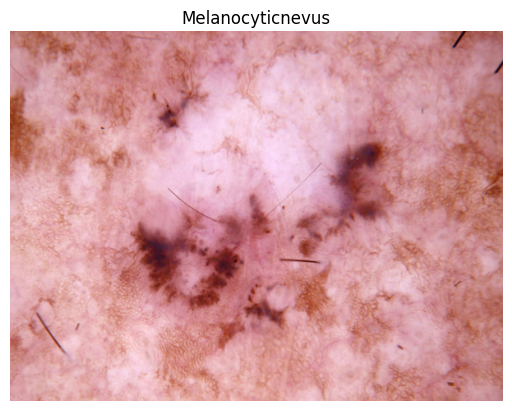

In [9]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Melanocyticnevus')

Image Shape : (450, 600, 3)


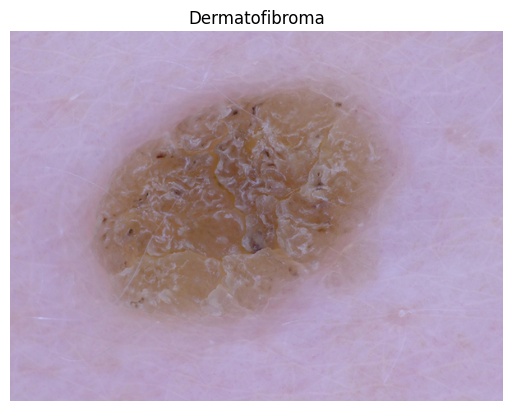

In [10]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Dermatofibroma')

Image Shape : (768, 1024, 3)


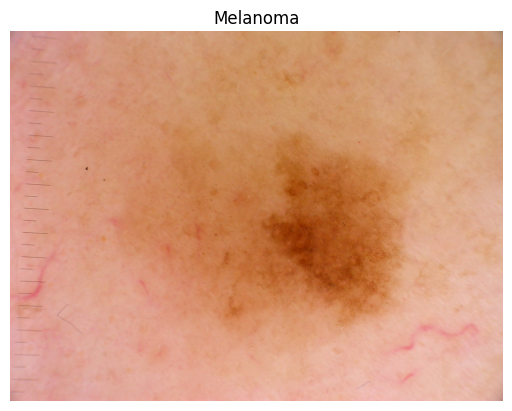

In [11]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Melanoma')

In [12]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [13]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 956 images belonging to 3 classes.
Found 254 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [14]:
train_data.class_indices

{'Dermatofibroma': 0, 'Melanocyticnevus': 1, 'Melanoma': 2}

In [15]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [16]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (956,)
val_y.shape:  (254,)
test_y.shape:  (66,)


In [17]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [18]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(3)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,040,579 (26.86 MB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=50, validation_data=valid_data)

Epoch 1/50


C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - accuracy: 0.3595 - loss: 1.2479 - val_accuracy: 0.4016 - val_loss: 1.1466
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.4273 - loss: 1.0565 - val_accuracy: 0.4567 - val_loss: 1.0615
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.5154 - loss: 0.9713 - val_accuracy: 0.5079 - val_loss: 0.9619
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.6075 - loss: 0.8962 - val_accuracy: 0.5748 - val_loss: 0.9143
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.6432 - loss: 0.8467 - val_accuracy: 0.5984 - val_loss: 0.8937
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.6877 - loss: 0.7955 - val_accuracy: 0.5787 - val_loss: 0.8604
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.6825 - loss: 0.7686 - val_accuracy: 0.6614 - val_loss: 0.8338
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.6973 - loss: 0.7413 - val_accuracy: 0.6220 - val_loss: 0.8310
Ep

In [21]:
import pickle

# Save history to a file
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [22]:
# Print training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print("Training Accuracy over epochs:")
print(train_accuracy)

print("\nValidation Accuracy over epochs:")
print(val_accuracy)

# Print final accuracy
print(f"\nFinal Training Accuracy: {train_accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")


Training Accuracy over epochs:
[0.35983264446258545, 0.46652719378471375, 0.5512552261352539, 0.6223849654197693, 0.6495816111564636, 0.6924686431884766, 0.6945606470108032, 0.7102510333061218, 0.7248954176902771, 0.7364016771316528, 0.7562761306762695, 0.7437238693237305, 0.75, 0.7531380653381348, 0.7646443247795105, 0.7824267745018005, 0.7740585803985596, 0.7928870320320129, 0.7981171607971191, 0.7981171607971191, 0.8033472895622253, 0.8138075470924377, 0.8012552261352539, 0.8169456124305725, 0.810669481754303, 0.8002092242240906, 0.7991631627082825, 0.8169456124305725, 0.8117154836654663, 0.8064853549003601, 0.819037675857544, 0.8127614855766296, 0.8294979333877563, 0.8284518718719482, 0.8274058699607849, 0.8211296796798706, 0.8274058699607849, 0.8441422581672668, 0.839958131313324, 0.8420501947402954, 0.8253138065338135, 0.8305439352989197, 0.8430962562561035, 0.8430962562561035, 0.8305439352989197, 0.8378661274909973, 0.8347280621528625, 0.8368200659751892, 0.8483263850212097, 0.8

In [23]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

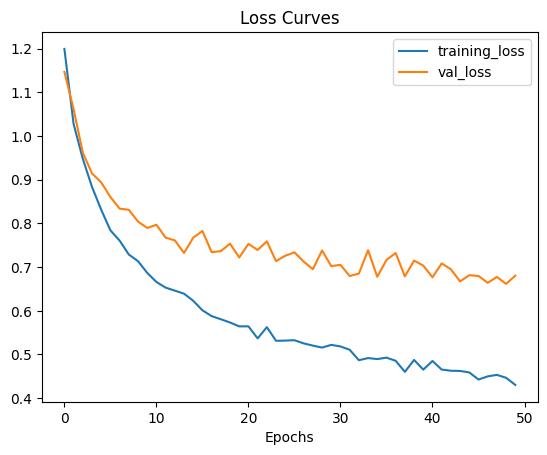

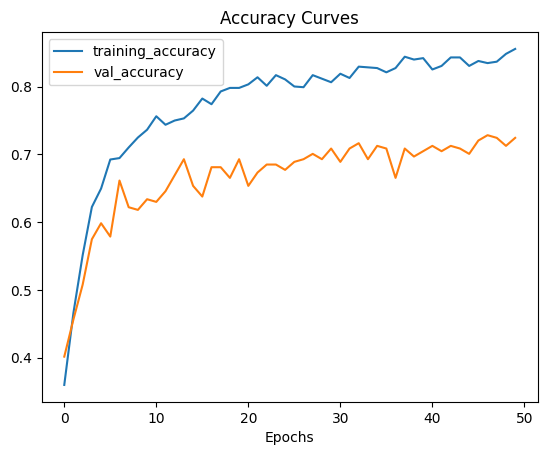

In [24]:
plot_loss_curves(history)

In [25]:
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step
              precision    recall  f1-score   support

           0       0.86      0.61      0.71       129
           1       0.51      0.69      0.58        55
           2       0.77      0.96      0.85        70

    accuracy                           0.72       254
   macro avg       0.71      0.75      0.72       254
weighted avg       0.76      0.72      0.72       254



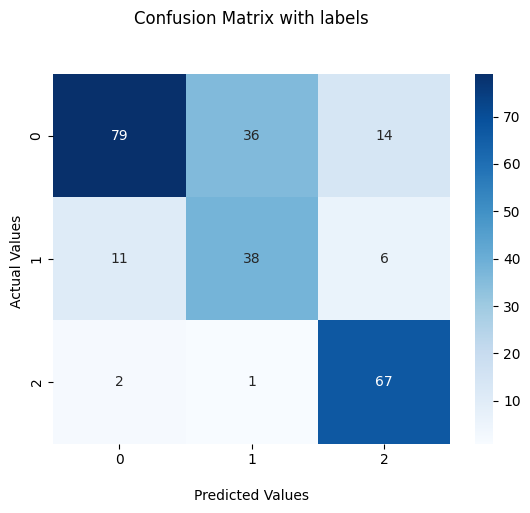

In [26]:
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [27]:
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step
              precision    recall  f1-score   support

           0       0.96      0.68      0.79        34
           1       0.53      0.83      0.65        12
           2       0.78      0.90      0.84        20

    accuracy                           0.77        66
   macro avg       0.76      0.80      0.76        66
weighted avg       0.83      0.77      0.78        66



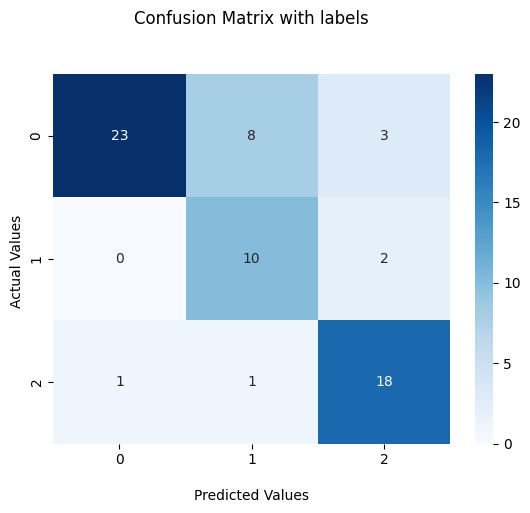

In [28]:
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [29]:
model.save('my_model.keras')

In [30]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [31]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import numpy as np
  
from keras.models import load_model
  
model = load_model('my_model.keras')
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\CNN_skin\dataset\Melanocyticnevus\ISIC_0000039_downsampled.jpg"

image = image.load_img(image_path, target_size=(224, 224))
#plt.imshow(image)

img = np.array(image)
img = img / 255.0
img = img.reshape(1,224,224,3)
label = model.predict(img)
#print(label)
if label[0][0] > label[0][1]:
    print('Dermatofibroma')
elif label[0][1] > label[0][2]:
    print('Melanocyticnevus')
elif label[0][2] > label[0][3]:
    print('Melanoma')
else:
    print('Enter A vaild image')


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ajayk\\Desktop\\InnoProjects\\CNN_skin\\dataset\\Melanocyticnevus\\ISIC_0000039_downsampled.jpg'

In [ ]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Load the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\SKIN_CANCER_DETECTION\dataset\Dermatofibroma\ISIC_0026417.jpg"
image = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 224, 224, 3)

# Predict the label
label = model.predict(img)

# Determine the predicted class
class_names = ['Dermatofibroma', 'Melanocyticnevus', 'Melanoma']
predicted_class_index = np.argmax(label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Disease :", predicted_class)

# Display the image with the predicted label
plt.imshow(image)
plt.title(predicted_class)
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Dermatofibroma


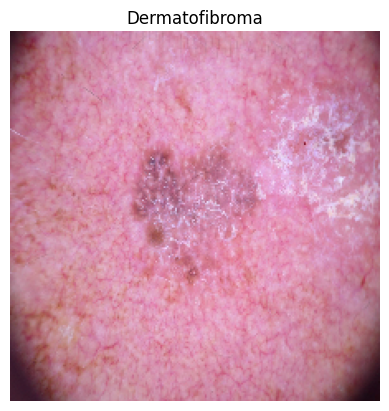

In [39]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Load the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\SKIN_CANCER_DETECTION\dataset\Dermatofibroma\ISIC_0025339.jpg"
image = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 224, 224, 3)

# Predict the label
label = model.predict(img)

# Determine the predicted class
class_names = ['Dermatofibroma', 'Melanocyticnevus', 'Melanoma'] 

predicted_class_index = np.argmax(label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class)

# Display the image with the predicted label
plt.imshow(image)
plt.title(predicted_class)
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


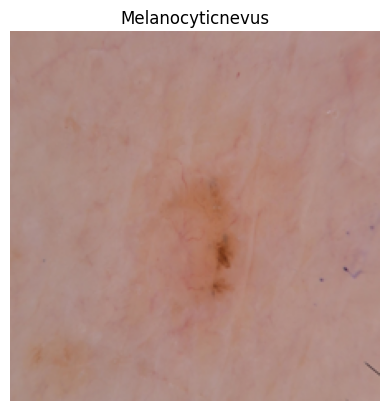

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


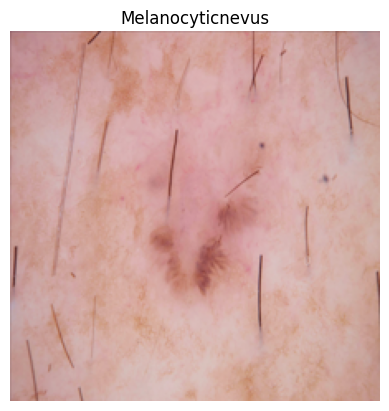

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


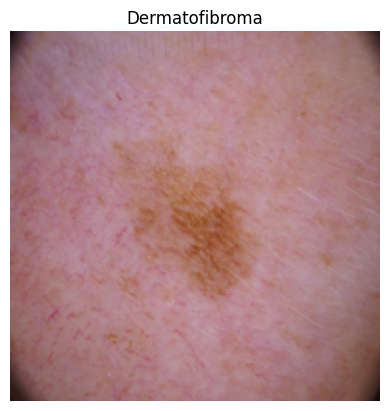

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\ajayk\anaconda3\envs\py310\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\ajayk\AppData\Local\Temp\ipykernel_13828\26647886.py", line 18, in classify_image
    image = Image.open(file_path)
  File "C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\PIL\Image.py", line 3277, in open
    fp = builtins.open(filename, "rb")
PermissionError: [Errno 13] Permission denied: 'C:\\Users\\ajayk\\Desktop\\InnoProjects\\SRIT\\SKIN_CANCER_DETECTION'


In [40]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Function to classify an image
def classify_image():
    # Load the trained model
    model = load_model('my_model.keras')
    
    # Open a dialog box to select an image file
    file_path = filedialog.askopenfilename()
    
    # Load the selected image
    image = Image.open(file_path)
    image = image.resize((224, 224))  # Resize the image to match model input size
    
    # Convert image to numpy array and preprocess
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1, 224, 224, 3)
    
    # Predict the label
    label = model.predict(img)
    
    # Determine the predicted class
    class_names = ['Dermatofibroma', 'Melanocyticnevus', 'Melanoma']
    predicted_class_index = np.argmax(label)
    predicted_class = class_names[predicted_class_index]
    
    # Display the image with the predicted label
    plt.imshow(image)
    plt.title(predicted_class)
    plt.axis('off')
    plt.show()

# Create a Tkinter window
root = tk.Tk()
root.title("Skin Cancer Classifier")

# Create a button to trigger image classification
classify_button = tk.Button(root, text="Classify Image", command=classify_image)
classify_button.pack(pady=10)

# Run the Tkinter event loop
root.mainloop()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define directories
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

# Image dimensions and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load data
train_data = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
val_data = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

# Function to create the model using VGG16
def create_vgg16_model():
    # Load pre-trained VGG16 base without the top layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the pre-trained layers
    base_model.trainable = False
    
    # Add custom layers on top of the VGG16 base
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(train_data.num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=output)
    
    return model

# Create the VGG16 model
vgg16_model = create_vgg16_model()

# Compile the model
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Print summary of the model
vgg16_model.summary()

# Train the VGG16 model
print("Training VGG16 Model...")
vgg16_model.fit(train_data, epochs=30, validation_data=val_data)

# Save the trained model
vgg16_model.save("vgg16_model.h5")
print("VGG16 Model saved as 'vgg16_model.h5'.")


In [ ]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the VGG16 model
vgg16_model = load_model('vgg16_model.h5')

# Make predictions for VGG16 model
vgg16_pred = vgg16_model.predict(test_data)
vgg16_pred = vgg16_pred.argmax(axis=1)  # Get class with highest probability

# True labels for the test set
test_y = test_data.classes

# Print classification report for VGG16 model
print("Classification Report for VGG16:")
print(classification_report(test_y, vgg16_pred))
